# **Exploratory Data Analysis (EDA)**



# 1. Import Necessary Libraries and datasets

 ##  a. Load libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import fuzzywuzzy
from fuzzywuzzy import process
import warnings
import os
#%matplotlib inline

warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/scooter_rental_data.csv


## b. Load dataset

In [2]:
data = pd.read_csv("../input/scooter_rental_data.csv")
print("Dataset loaded.")

Dataset loaded.


## c. Overview of dataset report

In [3]:
data.profile_report()

### Small feature engineering before seperating the dataset
> * Date is not compared in the correlation since its in data-time format.
> * Extract month feature from datatime to observe its correlation
> * Year not extracted due to limited observations in dataset (2011 and 2012 only)
> * Day is an insignificant correlation (extremely low correlation against target variables, 0.003)
> * Drop all the duplicate rows since they are redundant information

In [4]:
# Drop duplicates from dataset
data_dup_drop = data.drop_duplicates()
print(data.shape)
print(data_dup_drop.shape)
print("Number of duplicates dropped: ")
print("Rows: {}".format(data.shape[0] - data_dup_drop.shape[0]))
print("Columns: {}".format(data.shape[1] - data_dup_drop.shape[1]))
# Update old dataset to dataset without any duplicates, drop or not depends on requirements
data = data_dup_drop

(17958, 10)
(17379, 10)
Number of duplicates dropped: 
Rows: 579
Columns: 0


In [5]:
# Add month feature before seperating dataset
data['month'] = pd.to_datetime(data['date']).dt.month
# Month feature added
data.head()

date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  
0               81.0        0.0    3           21               164      1  
1               80.0        0.0   35           54               417      1  
2               80.0        0.0   38           35               356      1  
3               75.0        0.0   35           19               129      1  
4               75.0        0.0   11           -2                10      1

## d. Seperate dataset into train and test sets

In [6]:
# Seperate data into train and test set (80/20)
train = data.iloc[:-3480, :]     
test = data.iloc[-3480:, :]

In [7]:
# Describe full data, train and test sets
print("Original dataset has {} rows and {} columns.".format(data.shape[0], data.shape[1]))
print("\nSeperating dataset into train and test set...\n")
print("Train set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("Test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

Original dataset has 17379 rows and 11 columns.

Seperating dataset into train and test set...

Train set has 13899 rows and 11 columns.
Test set has 3480 rows and 11 columns.


## e. Understand training set

In [8]:
# Glimpse of train dataset
train.head()

date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  
0               81.0        0.0    3           21               164      1  
1               80.0        0.0   35           54               417      1  
2               80.0        0.0   38           35               356      1  
3               75.0        0.0   35           19               129      1  
4               75.0        0.0   11           -2                10      1

In [9]:
# Statistics information about train set
train.describe().T

count         mean          std   min    25%  \
hr                      13899.0    11.547162     6.913117   0.0    6.0   
temperature             13899.0    88.624462    16.726365  48.1   75.2   
feels-like-temperature  13899.0   117.581265    20.980098  60.8  100.4   
relative-humidity       13899.0    62.297360    19.821796   0.0   47.0   
windspeed               13899.0    13.005396     8.243456   0.0    7.0   
psi                     13899.0    24.485215    14.428544   0.0   12.0   
guest-users             13899.0   238.215987   331.396356  -2.0   26.0   
registered-users        13899.0  1827.155839  1786.938642  -5.0  406.0   
month                   13899.0     5.649471     3.218639   1.0    3.0   

                           50%     75%      max  
hr                        12.0    18.0     23.0  
temperature               88.7   102.2    131.0  
feels-like-temperature   118.4   134.6    179.6  
relative-humidity         62.0    79.0    100.0  
windspeed                 13.0    19.0     57.0  
psi                       24.0    37.0     49.0  
guest-users              107.0   322.0   2567.0  
registered-users        1386.0  2626.0  10348.0  
month                      5.0     8.0     12.0

In [10]:
# Understand each features datatype
train.dtypes

date                       object
hr                          int64
weather                    object
temperature               float64
feels-like-temperature    float64
relative-humidity         float64
windspeed                 float64
psi                         int64
guest-users                 int64
registered-users            int64
month                       int64
dtype: object

In [11]:
# Display no. of numerical and categorical data types
print("The total number of each data type: \n{}".format(train.get_dtype_counts()))

The total number of each data type: 
float64    4
int64      5
object     2
dtype: int64


# 2. Missing values

 > * #### Check for any missing values before looking at our features and observations
 > * #### Prepare certain functions to handle and view information of missing values (for future datasets)

In [12]:
# Only use this function if dataset contains missing values for observation
def list_missing(df):
    """Display features with missing values in a list
    
    Args:
        df (str): The dataframe (input dataset)
    
    Returns:
        list: list of missing amount and percentage belonging to features
    """
    # Total no. and % of missing values, more than 0 missing values
    total = df.isnull().sum().sort_values(ascending=False)[
            df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round((df.isnull().sum() / df.isnull().count() * 100).sort_values(
            ascending=False), 2)[round((df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False), 2) != 0]
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return(missing_data)

In [13]:
# Function to check for missing values in original data or cleaned data (2 usages)
def check_missing(df):
    """Check any missing data"""
    left = df.isnull().sum().max()
    if left == 0:
        print("No missing data")
    else:
        print("Missing data exists")   
    print("Dataset has {} rows and {} columns.".format(df.shape[0], df.shape[1]))

In [14]:
# Check train set for missing values (if any)
check_missing(train)

No missing data
Dataset has 13899 rows and 11 columns.


In [15]:
# Check test set for missing values (if any)
check_missing(test)

No missing data
Dataset has 3480 rows and 11 columns.


In [16]:
def heatmap_missing(df):
    """Heatmap showing missing values"""   
    colours = ['#000099', '#ffff00']        # Yellow = missing, Blue = not missing
    sns.heatmap(df.isnull(), cmap=sns.color_palette(colours)).set_title('Missing values')

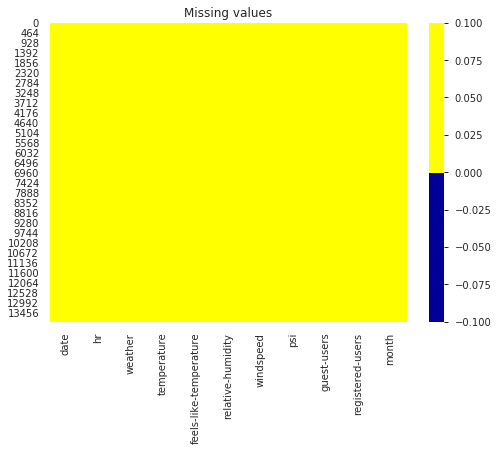

In [17]:
# Nice! No missing value at all (for future purposes if missing values involved)
heatmap_missing(train)

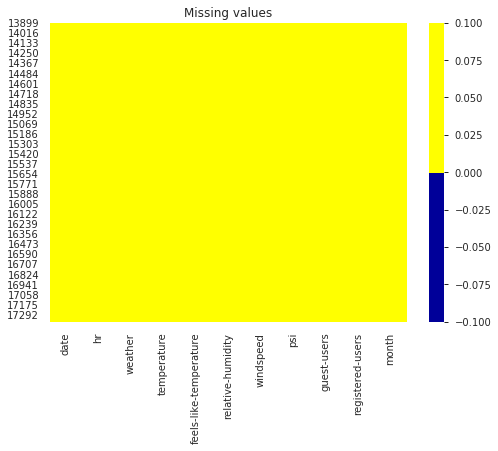

In [18]:
heatmap_missing(test)

# 3. Target variable

> #### It is very important to first understand our target variable(s) before proceeding with further steps.
> #### Target variable: Total number of users
> #### Made up of 2 target variables:
> ###### 1) guest-users
> ###### 2) registered-users

## a. Plot visualization charts

In [19]:
def plot_chart(df, feature):
    """Display histogram, boxplot and QQ plot graph
    
    Args:
        df (str): The dataframe (input dataset)
        feature (str): The target variable or any feature
    
    Returns:
        figure: A figure containing 3 plots for visualization  
    """
    sns.set(style='darkgrid')
    # Set figure dimension and allocate grids in figure
    fig = plt.figure(figsize=(12,8), constrained_layout=True)
    gs = fig.add_gridspec(3,3)
    # Histogram
    ax1 = fig.add_subplot(gs[0,:2])
    sns.distplot(df.loc[:,feature], ax=ax1).set_title('Histogram')   
    # QQ plot
    ax2 = fig.add_subplot(gs[1,:2])
    stats.probplot(df.loc[:, feature], plot=ax2)
    # Box plot
    ax3 = fig.add_subplot(gs[:,2])
    sns.boxplot(df.loc[:,feature], orient='v', ax=ax3).set_title('Box plot')

>  ### View target variables in histogram, boxplot and qq plot

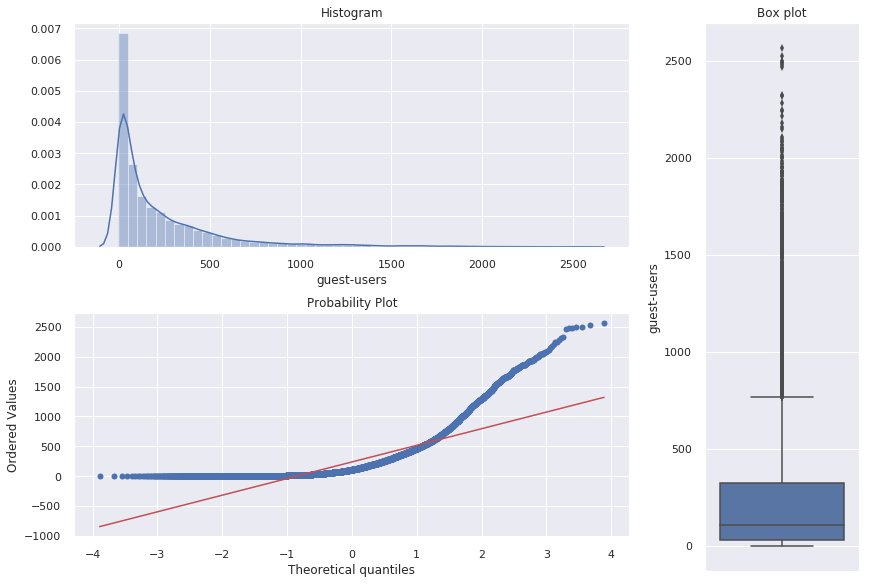

In [20]:
# Findings: abnormal distribution, right-skewed, outliers present
plot_chart(train, 'guest-users')

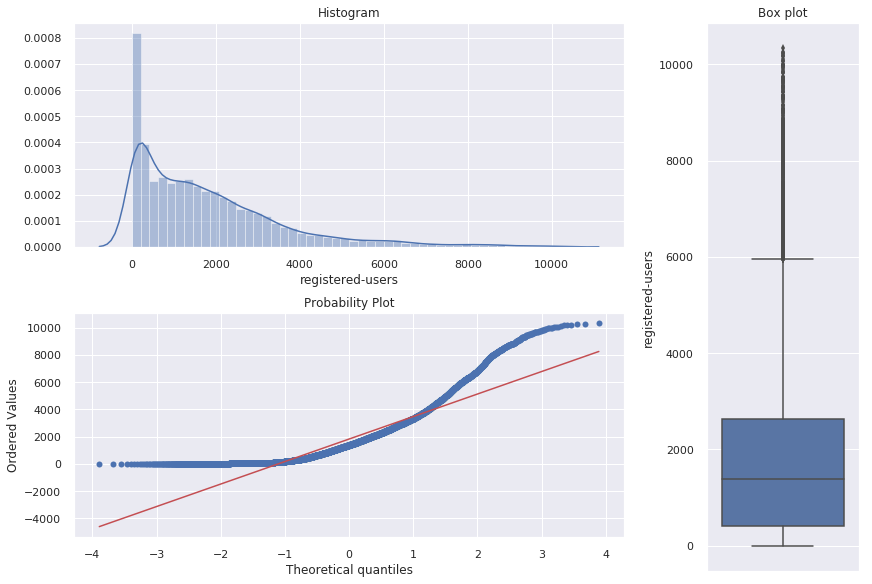

In [21]:
# Findings: abnormal distribution, right-skewed, lesser outliers present
plot_chart(train, 'registered-users')

## b. Check for Skewness and Kurtosis

In [22]:
def skew_kurtosis_value(df, feature):
    """ Function for skewness and kurtosis value
    
    Args:
        df (str): The dataframe (input dataset)
        feature (str): The target variable or any feature
    
    Returns:
        Skewness and kurtosis values
    """
    skewness = df[feature].skew()
    kurtosis = df[feature].kurt()

    print("Skewness: {}".format(round(skewness, 2)))
    if skewness > 0:
        print("Positive/right skewness: mean and median > mode.")
    else:
        print("Negative/left skewness: mean and median < mode")

    print("\nKurtosis: {}".format(round(kurtosis, 2)))
    if kurtosis > 3:
        print("Leptokurtic: more outliers")
    else:
        print("Platykurtic: less outliers")

In [23]:
# Guest users values
print("Guest users\n")
skew_kurtosis_value(train, 'guest-users')

Guest users

Skewness: 2.51
Positive/right skewness: mean and median > mode.

Kurtosis: 7.73
Leptokurtic: more outliers


In [24]:
# Registered users values
print("Registered users\n")
skew_kurtosis_value(train, 'registered-users')

Registered users

Skewness: 1.56
Positive/right skewness: mean and median > mode.

Kurtosis: 2.8
Platykurtic: less outliers


## c. Correlation of all features vs target variable

In [25]:
# Correlation of guest users vs all other features 
guest_feat = (train.corr())["guest-users"].sort_values(ascending=False)[1:]
print("Guest users")
guest_feat

Guest users


registered-users          0.516625
temperature               0.468155
feels-like-temperature    0.462490
hr                        0.304078
month                     0.084028
windspeed                 0.081420
psi                       0.000867
relative-humidity        -0.332278
Name: guest-users, dtype: float64

In [26]:
# Correlation of registered users vs all other features 
reg_feat = (train.corr())["registered-users"].sort_values(ascending=False)[1:]
print("Registered users")
reg_feat

Registered users


guest-users               0.516625
hr                        0.381840
temperature               0.361821
feels-like-temperature    0.358477
windspeed                 0.095297
month                     0.073075
psi                      -0.007870
relative-humidity        -0.284775
Name: registered-users, dtype: float64

> #### From above information (visualizaton charts, skew/kurt values, correlation stats table):
> #### We can infer that guest and registered users are highly correlated. 
> #### We can safely proceed on to combining guest and registered users into total users feature.

### Target variable: total-users

In [27]:
# Feature engineer new feature (guest + registered)
train['total-users'] = train['guest-users'] + train['registered-users']
test['total-users'] = test['guest-users'] + test['registered-users']

In [28]:
print("Added new feature: total-users")
train.head()

Added new feature: total-users


date  hr weather  temperature  feels-like-temperature  \
0  2011-01-01   0   clear         66.7                    95.0   
1  2011-01-01   1   clear         65.0                    93.2   
2  2011-01-01   2   clear         65.0                    93.2   
3  2011-01-01   3   clear         66.7                    95.0   
4  2011-01-01   4   clear         66.7                    95.0   

   relative-humidity  windspeed  psi  guest-users  registered-users  month  \
0               81.0        0.0    3           21               164      1   
1               80.0        0.0   35           54               417      1   
2               80.0        0.0   38           35               356      1   
3               75.0        0.0   35           19               129      1   
4               75.0        0.0   11           -2                10      1   

   total-users  
0          185  
1          471  
2          391  
3          148  
4            8

In [29]:
# Correlation of total-user vs other features
total_feat = (train.corr())["total-users"].sort_values(ascending=False)[1:]
total_feat

registered-users          0.989664
guest-users               0.634072
temperature               0.405184
feels-like-temperature    0.401216
hr                        0.395782
windspeed                 0.099703
month                     0.080070
psi                      -0.006963
relative-humidity        -0.312844
Name: total-users, dtype: float64

In [30]:
# Total users values
skew_kurtosis_value(train, 'total-users')

Skewness: 1.36
Positive/right skewness: mean and median > mode.

Kurtosis: 1.91
Platykurtic: less outliers


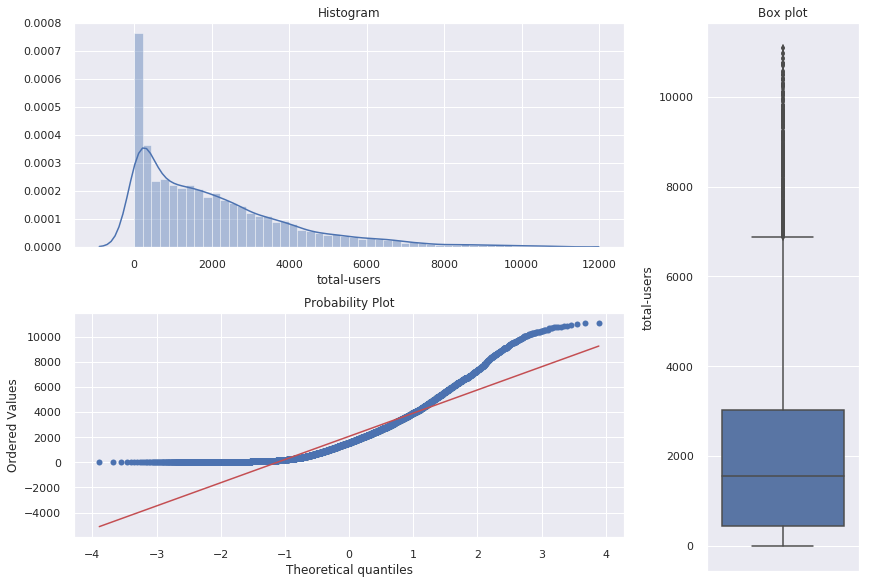

In [31]:
# Findings: abnormal distribution, right-skewed, lesser outliers present
plot_chart(train, 'total-users')

# 4. Correlation charts

## a. Heatmap

Text(0.5, 1.0, 'All features heatmap')

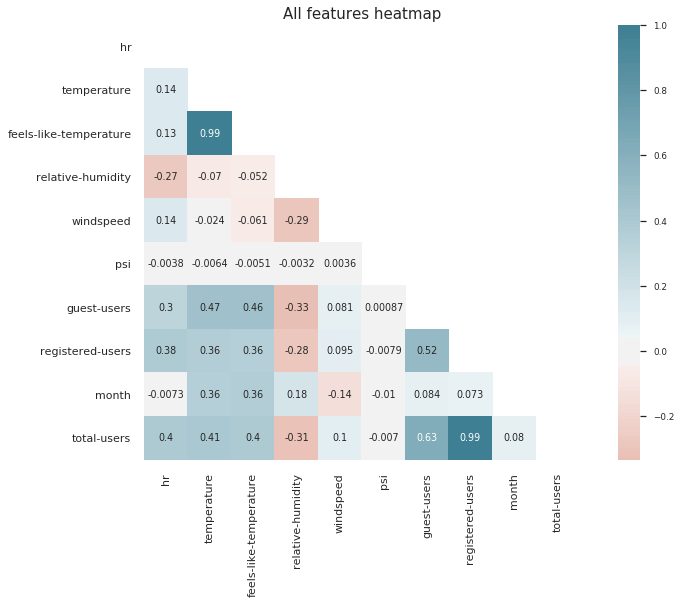

In [32]:
# Correlation matrix in heatmap
sns.set_style('whitegrid')
plt.subplots(figsize = (14,8))
# Generate mask for upper triangle
m1 = np.zeros_like(train.corr(), dtype=np.bool)     
m1[np.triu_indices_from(m1)] = True
sns.set(font_scale=0.8)
sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), 
            mask=m1, center=0, square=True, annot=True)
plt.title("All features heatmap", fontsize=15)

### Observation
> #### From the heatmap, we can see that multicollinearity exists in some features. E.g. total users, guest and registered.
> #### We will use regularization models such as Ridge, Lasso,ElasticNet for cleaning up later.
* 40% correlation between total-users and hr, temperature, feels-like-temperature
* 64% correlation between total-users and guest users
* 99% corrrelation between total-users and registered users

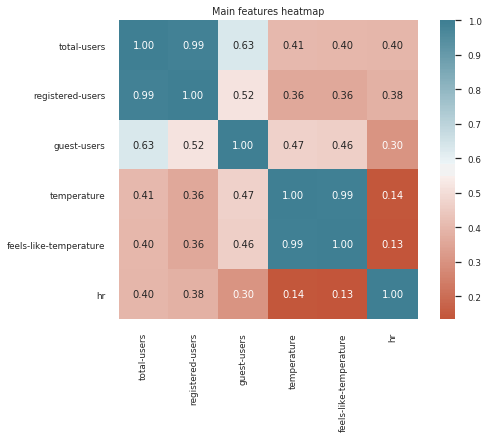

In [33]:
# Main features focused heatmap
n = 6      # Number of variables
features = train.corr().nlargest(n, 'total-users')['total-users'].index
hm_data = np.corrcoef(train[features].values.T)
sns.set(font_scale=0.8)
hm = sns.heatmap(hm_data, cbar=True, cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=features.values, xticklabels=features.values).set_title("Main features heatmap")

## b. Scatter plots

In [34]:
# Scatter plot features to compare
features = ['total-users', 'temperature', 'feels-like-temperature', 'hr', 'month', 'windspeed']

def scatter_plots(df, features):
    """Scatter plots of main features vs target variable
    
    Args:
        df (str): The dataframe (input dataset)
        features (list): A list of feature variables
    
    Returns:
        figure: scatter plots of each feature vs target variable 
    """
    sns.set()
    sns.pairplot(df[features], size=3)

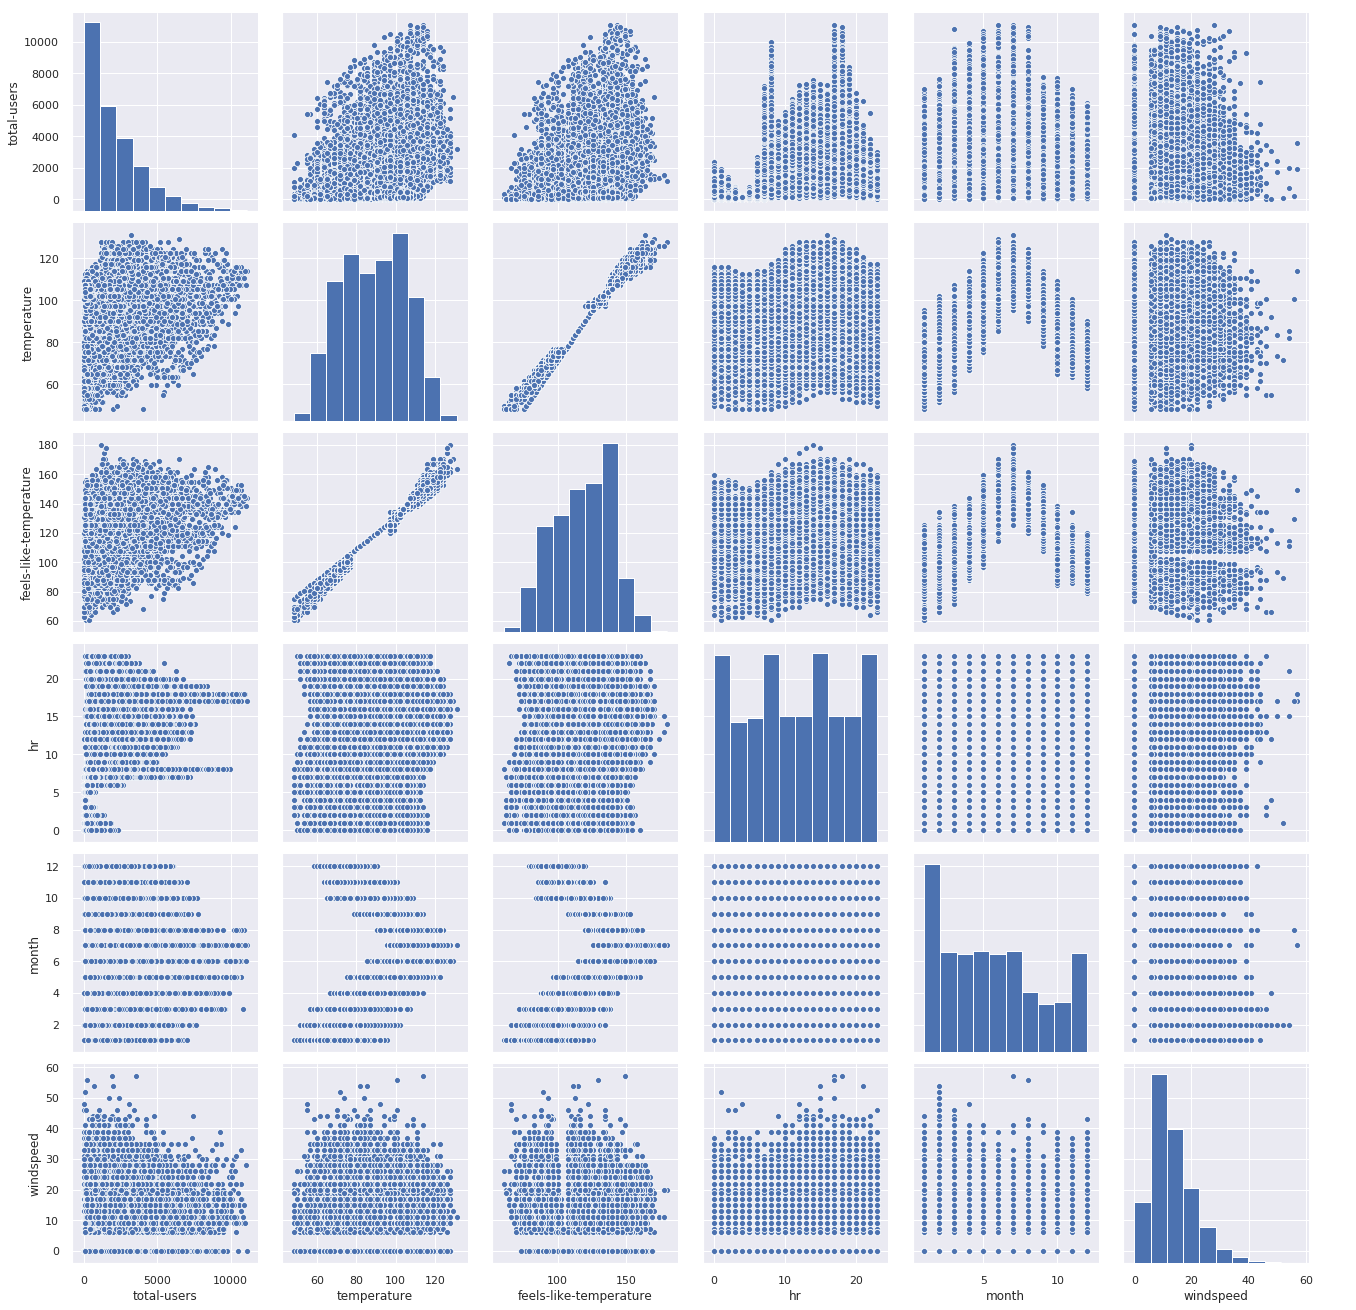

In [35]:
scatter_plots(train, features)

> ### Based on the scatter plots above:
* we can see several features with linear relationship with the target variable
* the most popular hr and month periods
* Outliers not visibly present (features vs target plots)

# 5. Outliers

## a. Univariate analysis

* Establish a threshold to determine an outlier
* Done by standardize data: convert data values to their mean value = 0 and SD = 1

In [36]:
# Adjusted total user, increase array dimension by 1
total_users_adj = StandardScaler().fit_transform(train['total-users'][:, np.newaxis])
high_range = total_users_adj[total_users_adj[:, 0].argsort()][-10:]     # last 10 in range
low_range = total_users_adj[total_users_adj[:, 0].argsort()][:10]       # first 10 in range
print('Outer low range of the distribution:')
print(low_range)
print('\nOuter high range of the distribution:')
print(high_range)

Outer low range of the distribution:
[[-1.04338861]
 [-1.04237776]
 [-1.04237776]
 [-1.04187233]
 [-1.0413669 ]
 [-1.0413669 ]
 [-1.04086148]
 [-1.04086148]
 [-1.04035605]
 [-1.04035605]]

Outer high range of the distribution:
[[4.37781802]
 [4.37983973]
 [4.38590485]
 [4.39146454]
 [4.43543666]
 [4.44049093]
 [4.49153902]
 [4.49760414]
 [4.55421193]
 [4.56128791]]


> Findings:
> * Low range values close to 0
> * High range values far from 0
> * No outliers present

## b. Bivariate analysis
* Use scatter plot for numerical features to find outliers
* Use box plot for catergorical feature to find outliers

In [37]:
# Using statistics to check for outliers in temperature first
feature = 'temperature'
train[feature].describe()                
print("Max value of temperature: {}\n75th percentile value of weather: {}\nNo obvious outlier present".format(train[feature].max(), train[feature].quantile(0.75)))

Max value of temperature: 131.0
75th percentile value of weather: 102.2
No obvious outlier present


In [38]:
# Bivariate analysis, scatter plot in-depth look
def bivariate_scatter(df, predictor, target):
    data = pd.concat([df[target], df[predictor]], axis=1)
    data.plot.scatter(x=predictor, y=target)

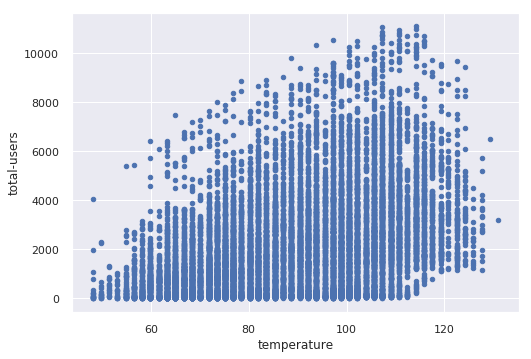

In [39]:
# Temperature vs total users
bivariate_scatter(train, 'temperature', 'total-users')

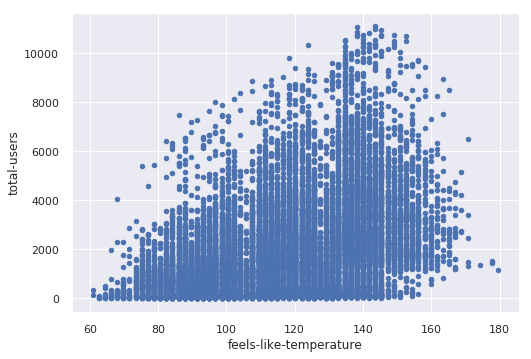

In [40]:
# Feels-like-temperature vs total users
bivariate_scatter(train, 'feels-like-temperature', 'total-users')

In [41]:
def bivariate_boxplot(df, predictor, target):
    data = pd.concat([train[target], train[predictor]], axis=1)
    fig = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(data=data, x=predictor, y=target)

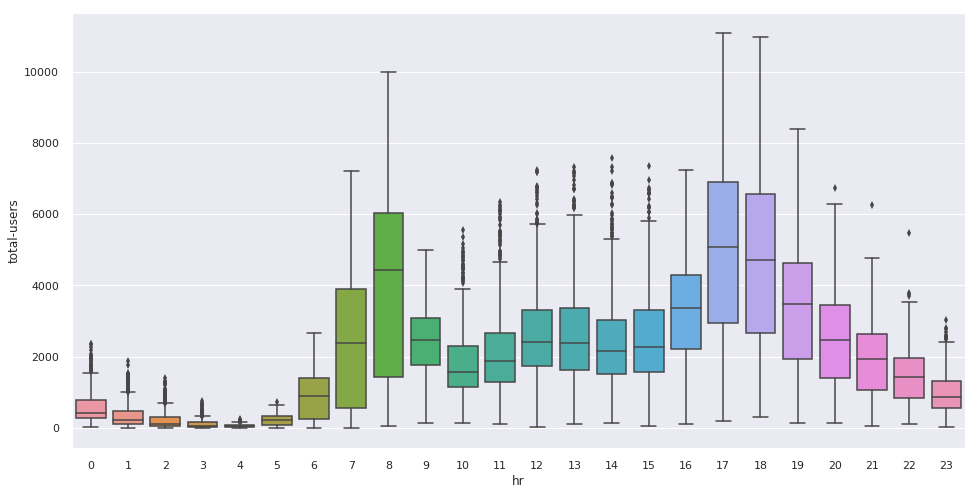

In [42]:
# Box plot hr vs total-users
bivariate_boxplot(train, 'hr', 'total-users')

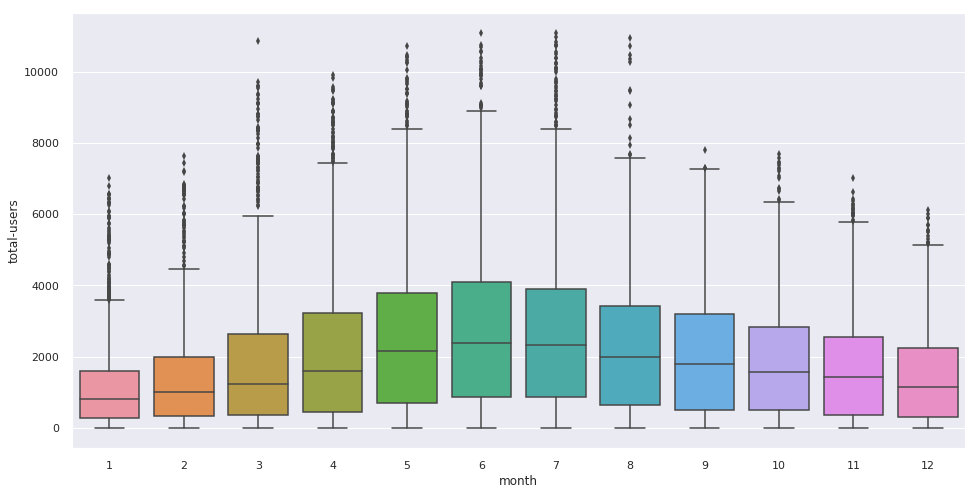

In [43]:
# Month vs total users
bivariate_boxplot(train, 'month', 'total-users')

> ### Use box plot to visualize relationship among categorical feature

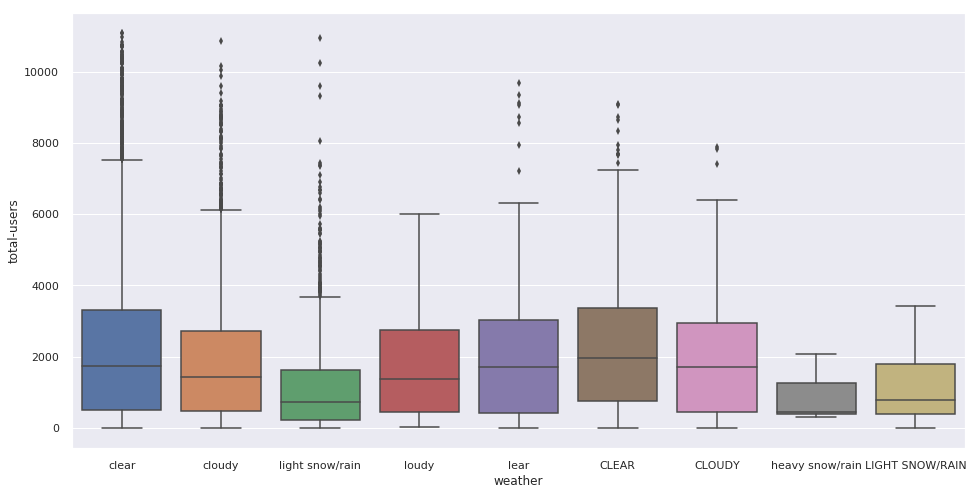

In [44]:
# Box plot weather vs total-users
bivariate_boxplot(train, 'weather', 'total-users')

> #### Based on above charts, we can see several outliers and feature's classes that requires feature engineering. It has inconsistent catergorical values in the data. E.g. Classes with spelling error: cloudy spelled as loudy or CLOUDY.
* Several outliers are shown in the month feature's classes. However, they could be ignored as there will be some days in the month or day where there will be more total users (E.g. weekends, public holidays)
* Some outliers found in hr feature's classes (late timings) can be ignored too since there may be some people who likes to enjoy the night breeze occansionally (which suggests the little amt of outliers).
* The noon timings consists of more outliers which may be the rise in food delivery services or those people going out for lunch etc. It need not to be removed as during model fitting, we will rely on certain techniques to prevent outliers from affecting our model.

> #### We will do feature engineering later to get rid of all the inconsistency issue.

## c. Check for regression and fix target variable

In [45]:
# Make a train copy to compare before and after transformation chart
pre_train = train.copy()

In [46]:
def regression_check(df, y, x1, x2): 
    """Find regression in features using scatter plot and regular lines"""
    fig, (ax1, ax2) = plt.subplots(figsize=(16,6), ncols=2, sharey=False)
    # Scatter plot for y vs x1 
    sns.scatterplot(x=df[x1], y=df[y], ax=ax1)
    # Add regression line.
    sns.regplot(x=df[x1], y=df[y], ax=ax1)
    
    # Scatter plot for y vs x2
    sns.scatterplot(x=df[x2], y=df[y], ax=ax2)
    # Add regression line 
    sns.regplot(x=df[x2], y=df[y], ax=ax2)

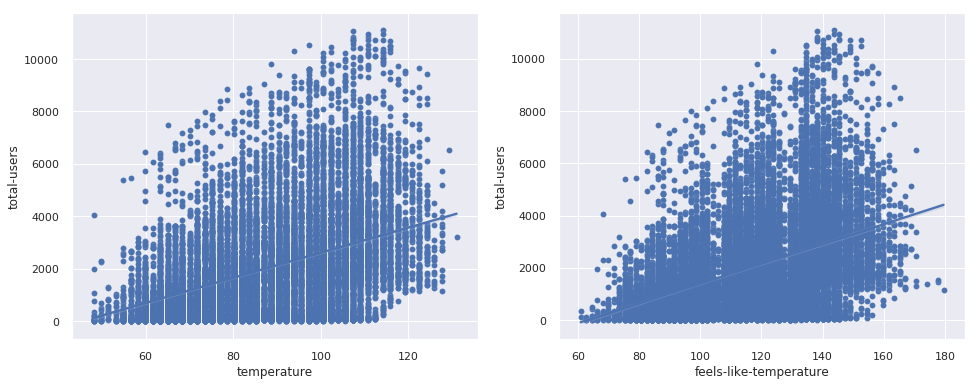

In [47]:
# Check for regression in features
regression_check(train, 'total-users', 'temperature', 'feels-like-temperature')

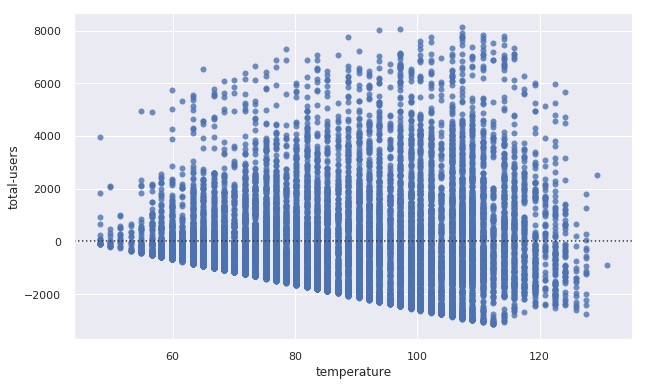

In [48]:
# Find error variance across true line
plt.subplots(figsize = (10,6))
sns.residplot(train['temperature'], train['total-users'])

> ### Transform target variable using log transformation

Before transformation


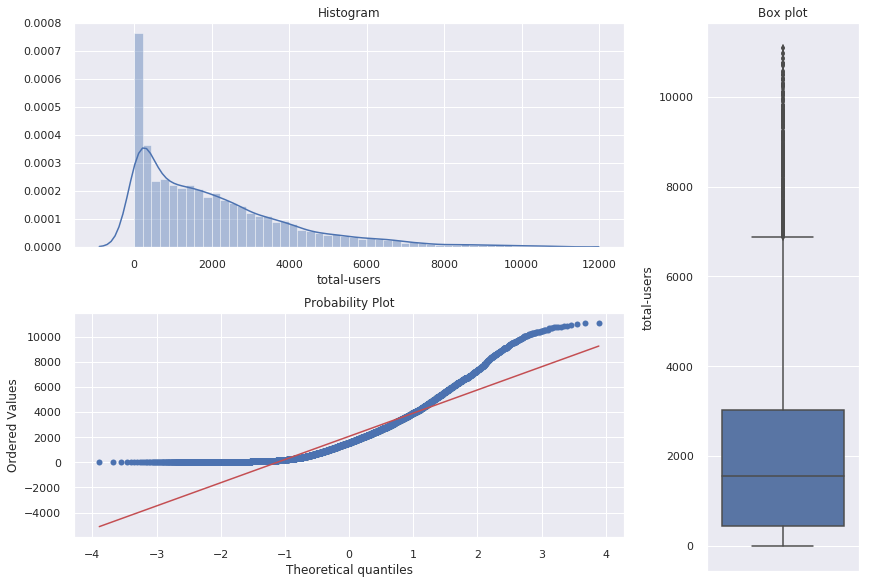

In [49]:
# Before transformation
print("Before transformation")
plot_chart(train, 'total-users')

In [50]:
"""
# Transform target variable using log transformation
train["total-users"] = np.log1p(train["total-users"])
print("After transformation")
# Plot newly transformed
plot_chart(train, 'total-users')
"""

'\n# Transform target variable using log transformation\ntrain["total-users"] = np.log1p(train["total-users"])\nprint("After transformation")\n# Plot newly transformed\nplot_chart(train, \'total-users\')\n'

Text(0.5, 1.0, 'After')

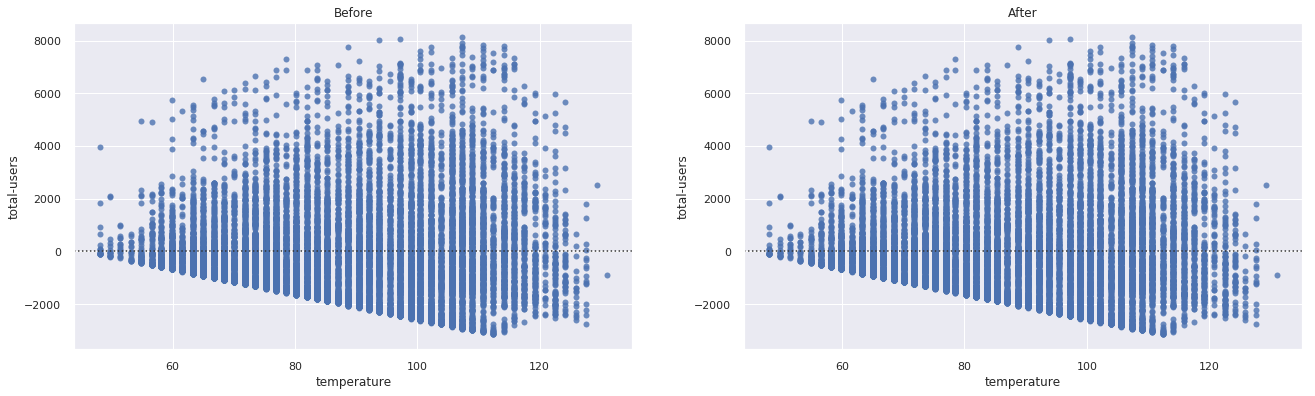

In [51]:
# Comparing before and after adjusted target vs feature 
fig, (ax1, ax2) = plt.subplots(figsize=(22, 6), ncols=2, sharey=False, sharex=False)
sns.residplot(x=pre_train['temperature'], y=pre_train['total-users'], ax=ax1).set_title('Before')
sns.residplot(x=train['temperature'], y=train['total-users'], ax=ax2).set_title('After')

# 6. Feature Engineering

## a. Repetitive values

In [52]:
# Saving the target variable for y train set 
y = train['total-users'].reset_index(drop=True)

# Saving the target variable for y test set
y_test = test['total-users'].reset_index(drop=True)

# Combine train and test datasets together
full_data = pd.concat((train, test)).reset_index(drop=True)
# Remove the target variable 
full_data.drop(['total-users'], axis=1, inplace=True)

In [53]:
def repetitive(df): 
    """Find features with above 95% repeated values"""
    total_rows = df.shape[0]  
    for col in df.columns:
        count = df[col].value_counts(dropna=False)
        high_percent = (count/total_rows).iloc[0]      
        if high_percent > 0.95:
            print('{0}: {1:.1f}%'.format(col, high_percent*100))
            print(count)
            print()

In [54]:
# View and understand repetitive reason, drop if uninformative (Result: no repetitive values)
repetitive(full_data)

## b. Duplicates

In [55]:
# Check for any duplicates left
data_dup_drop = full_data.drop_duplicates()
print(full_data.shape)
print(data_dup_drop.shape)
print("Number of duplicates dropped: ")
print("Rows: {}".format(full_data.shape[0] - data_dup_drop.shape[0]))
print("Columns: {}".format(full_data.shape[1] - data_dup_drop.shape[1]))

(17379, 11)
(17379, 11)
Number of duplicates dropped: 
Rows: 0
Columns: 0


## c. Fix skewed features

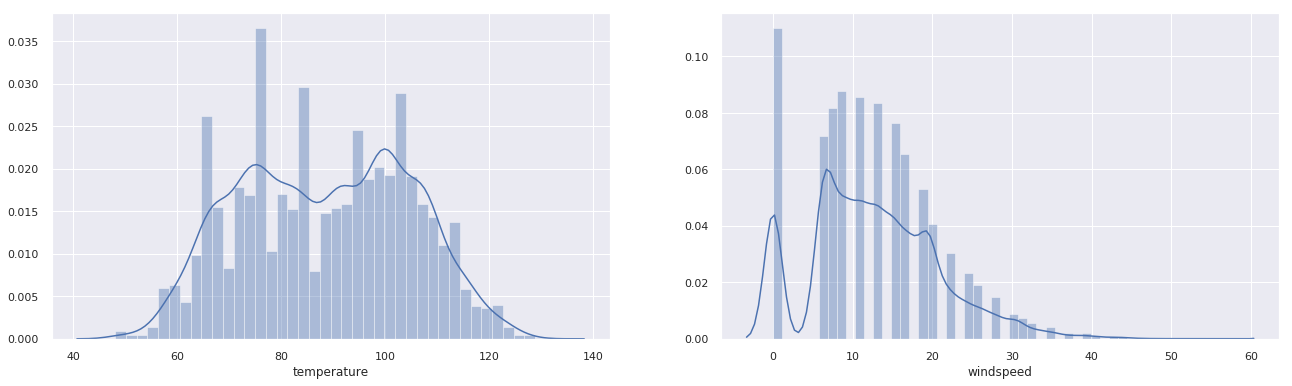

In [56]:
# Examples of skewed features
fig, (ax1, ax2) = plt.subplots(figsize=(22, 6), ncols=2, sharey=False, sharex=False)
sns.distplot(full_data['temperature'], ax=ax1)
sns.distplot(full_data['windspeed'], ax=ax2)

In [57]:
# Very little features are skewed
num_feat = full_data.dtypes[train.dtypes != "object"].index
skewed_num_feat = full_data[num_feat].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_num_feat

guest-users               2.498891
registered-users          1.557765
windspeed                 0.574794
psi                      -0.001310
temperature              -0.006289
month                    -0.009252
hr                       -0.010679
feels-like-temperature   -0.090470
relative-humidity        -0.111278
dtype: float64

> ### Fix skewness using boxcox transformation

In [58]:
def fix_skewness(df):
    """Fix skewness in dataframe
    
    Args:
        df (str): The dataframe (input dataset)
    
    Returns:
        df (str): Fixed skewness dataframe 
    """  
    # Skewness of all numerical features
    num_feat = df.dtypes[df.dtypes == ("float64" or "int64")].index
    skewed_num_feat = df[num_feat].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_num_feat[abs(skewed_num_feat) > 0.5].index       # high skewed if skewness above 0.5
    
    # Use boxocx transformation to fix skewness
    for feat in high_skew:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

In [59]:
fix_skewness(full_data)
print("Skewness fixed")

Skewness fixed


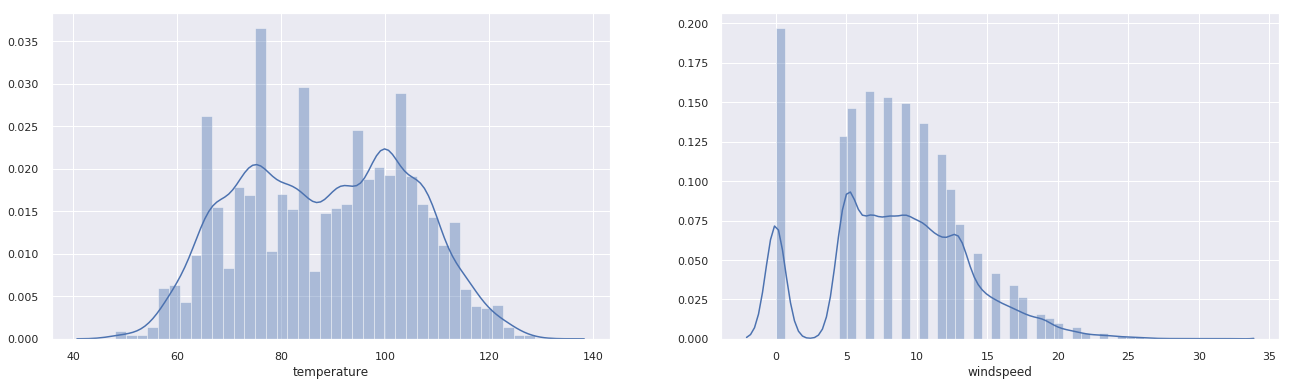

In [60]:
# Fixed skewed features
fig, (ax1, ax2) = plt.subplots(figsize=(22, 6), ncols=2, sharey=False, sharex=False)
sns.distplot(full_data['temperature'], ax=ax1)
sns.distplot(full_data['windspeed'], ax=ax2)

## d. Fix inconsistent data

In [61]:
# Before fixing inconsistent/typo/error classes
full_data.weather.value_counts()

clear              10830
cloudy              4343
light snow/rain     1390
lear                 311
CLEAR                272
loudy                107
CLOUDY                94
LIGHT SNOW/RAIN       29
heavy snow/rain        3
Name: weather, dtype: int64

> #### Categorical feature usually contains alot of inconsistent data:
* Capitalization
* Formats
* Categorical Values
* Addresses

> #### In this dataset, there's only 1 categorical feature: weather
> #### As shown above, it contains capitalization and categorical values error.
> #### The issues will be addressed in the following code sections

In [62]:
# View all the different classes
weather = full_data.weather.unique()
weather.sort()
weather

array(['CLEAR', 'CLOUDY', 'LIGHT SNOW/RAIN', 'clear', 'cloudy',
       'heavy snow/rain', 'lear', 'light snow/rain', 'loudy'],
      dtype=object)

In [63]:
# Change everything to lower case for consistency and precised value placement
full_data['weather'] = full_data['weather'].str.lower()
# Remove trailing whitespaces (in case)
full_data['weather'] = full_data['weather'].str.strip()

In [64]:
# After adjusted to lower case
weather = full_data.weather.unique()
weather.sort()
weather

array(['clear', 'cloudy', 'heavy snow/rain', 'lear', 'light snow/rain',
       'loudy'], dtype=object)

In [65]:
# get the top 10 closest matches to "clear"
matches = fuzzywuzzy.process.extract("cloudy", weather, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches

[('cloudy', 100),
 ('loudy', 91),
 ('clear', 36),
 ('lear', 20),
 ('light snow/rain', 19),
 ('heavy snow/rain', 10)]

### Reusable function code for future cleaning of inconsistent dataset

In [66]:
def replace_matches_in_column(df, feature, class_to_match, min_ratio):
    # List of classes in feature
    list_class = df[feature].unique()
    
    # Top 10 closest matches
    matches = fuzzywuzzy.process.extract(class_to_match, list_class, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # Matches with a high ratio (set by user)
    close_matches = [m[0] for m in matches if m[1] >= min_ratio]

    # Rows of all the close matches in our dataframe
    rows_matches = df[feature].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_matches, feature] = class_to_match
    
    # let us know the function's done
    print("REPLACED!")

In [67]:
# Replace incorrect to specified correct class name
replace_matches_in_column(full_data, 'weather', 'clear', 80)

REPLACED!


In [68]:
# Replace incorrect to specified correct class name
replace_matches_in_column(full_data, 'weather', 'cloudy', 80)

REPLACED!


In [69]:
# View corrected feature classes
full_data.weather.value_counts()

clear              11413
cloudy              4544
light snow/rain     1419
heavy snow/rain        3
Name: weather, dtype: int64

## e. Add dummies!

In [70]:
# Before that, we need to drop the date column since its not correlated to the target variable, month and hr are sufficient
full_data.drop(['date'], axis=1, inplace=True)
full_data.shape

(17379, 10)

In [71]:
# Create dummy variabes
full_data = pd.get_dummies(full_data).reset_index(drop=True)
full_data.shape

(17379, 13)

In [72]:
# Take as many rows as y dataset, all columns (train and validation set)
X = full_data.iloc[:len(y), :]
# Take the rest of the rows and all columns (submission test set)
X_test = full_data.iloc[len(y):, :]

In [73]:
print(full_data.shape, X.shape, y.shape, X_test.shape, y_test.shape)

(17379, 13) (13899, 13) (13899,) (3480, 13) (3480,)


> #### Check for overfitting features, remove if found

In [74]:
def overfit_features(df):
    """Find a list of features that are overfitted"""
    overfit = []
    for col in df.columns:
        counts = df[col].value_counts().iloc[0]
        if counts / len(df)*100 > 99.94:
            overfit.append(col)
    return overfit

overfits = overfit_features(X)

print("List of overfitted features: \n{}".format(overfits))
X = X.drop(overfits, axis=1)
print("List of overfitted features: \n{}".format(overfits))
X_test = X_test.drop(overfits, axis=1)

List of overfitted features: 
['weather_heavy snow/rain']
List of overfitted features: 
['weather_heavy snow/rain']


# 7. Algorithm Selection

## a. Split train set and define optimal threshold

In [75]:
# Split train data into train/test sets, k num of folds, shuffle data before split, set constant random generator 
k_folds = KFold(n_splits=10, shuffle=True, random_state=0)

def rmseCV(model, X=X):
    """Root mean squared error"""
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                    scoring="neg_mean_squared_error", cv=k_folds))
    return rmse

In [76]:
# Assign diff alphas values to find best fit for model
r_alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
l_alphas = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]     # values close to 1 better choice based on documentation

## b. Regularization models

In [77]:
# Regularization models (prevent overfitting using penalty on coeff), use pipelines
# Ridge model using pipeline to add robustscaler (scale feature based on percentiles, wont be affected by outliers)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=r_alphas, cv=k_folds))
# Lasso model
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=l_alphas, max_iter=1e7, cv=k_folds, random_state=0))
# ElasticNet model
elastic_net = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=e_l1ratio, alphas=e_alphas, max_iter=1e7, cv=k_folds))
# Support Vector Regression (SVR) used for working with continuous values (tune para for diff results)
svr = make_pipeline(RobustScaler(), SVR(gamma=0.0003, C=20, epsilon=0.008))    # Small gamma value define a Gaussian function with a large variance

# Light GBM
lightgbm = LGBMRegressor(objective='regression', num_leaves=4, learning_rate=0.01, n_estimators=5000,
                         max_bin=200, bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
                         feature_fraction=0.2, feature_fraction_seed=7, verbose=-1)
# XGBoost
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460, max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7, colsample_bytree=0.7, objective='reg:linear', nthread=-1, 
                       scale_pos_weight=1, seed=27, reg_alpha=0.00006)
# Emsemble learning, using multiple regressors to predict 
stack_reg = StackingCVRegressor(regressors=(ridge, lasso, elastic_net, svr, lightgbm, xgboost),
                                meta_regressor=xgboost, use_features_in_secondary=True)

## c. Score each algorithms

In [78]:
# Score of each model
score = rmseCV(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(elastic_net)
print("Elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(lightgbm)
print("LightGBM: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(xgboost)
print("Xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

score = rmseCV(stack_reg)
print("Stack: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now())

Ridge: 3.8463 (0.1807)
 2020-03-11 23:13:06.866512
LASSO: 1.1323 (0.0429)
 2020-03-11 23:13:08.151894
Elastic net: 1.1282 (0.0399)
 2020-03-11 23:13:13.116412
SVR: 1874.4543 (72.8276)
 2020-03-11 23:15:31.405371
LightGBM: 131.6397 (4.7894)
 2020-03-11 23:15:52.139390
[23:15:52] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:16:19] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:16:45] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:12] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:39] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:18:06] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated 

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'] ['hr', 'temperature', 'feels-like-temperature', 'relative-humidity', 'windspeed', 'psi', 'guest-users', 'registered-users', 'month', 'weather_clear', 'weather_cloudy', 'weather_light snow/rain']
expected f8, f10, f11, f4, f3, f7, f6, f1, f5, f2, f0, f9 in input data
training data did not have the following fields: relative-humidity, psi, guest-users, windspeed, month, registered-users, temperature, weather_clear, weather_light snow/rain, weather_cloudy, feels-like-temperature, hr

# 8. Fit Model

In [79]:
# Fit model
print('Fitting Model...')

print('Ridge') 
ridge_model = ridge.fit(X, y)

print('Lasso')
lasso_model = lasso.fit(X, y)

print('ElasticNet')
elastic_model = elastic_net.fit(X, y)

print('SVR')
svr_model = svr.fit(X, y)

print('LightGBM')
lgb_model = lightgbm.fit(X, y)

print('XGBoost')
xgb_model = xgboost.fit(X, y)

print('StackRegressor')
stack_reg_models = stack_reg.fit(np.array(X), np.array(y))

Fitting Model...
Ridge
Lasso
ElasticNet
SVR
LightGBM
XGBoost
[23:25:04] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
StackRegressor
[23:26:56] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:22] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:46] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:10] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:34] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:59] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[23:30:02] WARNING: /workspace/src/

## Blending models!!!
> #### Combine models for the best prediction
> #### Tunable parameters for best outcome
* Best prediction value comes from xgb and stack regressor.
* Percentage is tunable but should not be overadjusted towards certain models
* This prevents overfitting as this model could be tested with different datasets that contains more outliers
* Ridge is to ensure robustness in the model even though it predicted worse than others in this dataset

In [80]:
# Percentage of each models is tunable for best overall prediction value
def blend_models_predict(X):
    return ((0.1 * ridge_model.predict(X)) +
            (0.01 * lasso_model.predict(X)) + 
            (0.02 * elastic_model.predict(X)) +    
            (0.02 * svr_model.predict(X)) + 
            (0.1 * lgb_model.predict(X)) + 
            (0.35 * xgb_model.predict(X)) +             
            (0.4 * stack_reg_models.predict(np.array(X))))

### Root mean squared log error(RMSLE) chosen to scale down outliers, nullify their effects
* only consider relative error:
* relative error = absolute error(magnitude of error) / exact value (magnitude)
* E.g:
* y=100, X_pred=90 => RMSLE (cal relative error)=10/100 = 0.1
* y=10000, X_pred=9000 => RMSLE=1000/10000 = 0.1
* biased penalty:
* larger penalty for underestimation of value than overestimation
* E.g:
* y=1000, X_pred=600 => RMSLE = 0.51 (underestimation)
* y=1000, X_pred=1400 => RMSLE = 0.33 (overestimation)
* Overestimated sale price: if sell more to earn, if buy more money prepared
* Useful for delivery time regression problem

In [81]:
# RMSLE
def rmsle(y, y_pred):
    """root mean squared log error(RMSLE) chosen to scale down outliers, nullify their effects (robust)"""
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y))**2))

In [82]:
# RMSE
def rmse(y, y_pred):
    """root mean squared error(RMSE), prone to outliers"""
    return np.sqrt(mean_squared_error(y, y_pred))

In [83]:
blend_models_predict(X)

array([ 218.56226985,  477.41750012,  404.82271245, ...,  456.91995093,
       2241.22301825, 6282.62324458])

## Test accuracy score

#### Train set

In [84]:
# Training set accuracy score, lower RMSLE better accuracy
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.21672846184976596


In [85]:
# Training set accuracy score, lower RMSE better accuracy
print('RMSE score on train data:')
print(rmse(y, blend_models_predict(X)))

RMSE score on train data:
43.219410245364706


#### Test set

In [86]:
# Test set accuracy score, lower RMSLE better accuracy
print('RMSLE score on test data:')
print(rmsle(y_test, blend_models_predict(X_test)))

RMSLE score on test data:
0.13601520056514757


In [87]:
# Test set accuracy score, lower RMSE better accuracy
print('RMSE score on test data:')
print(rmse(y_test, blend_models_predict(X_test)))

RMSE score on test data:
96.14580898640934


## Finally, submission!

In [88]:
# Create new submission file for prediction values
print('Submit prediction')
# pred_test = np.floor(np.expm1(blend_models_predict(X_test)))
pred_test = blend_models_predict(X_test)
submission = pd.DataFrame({'Id': X_test.index, 'total-users': pred_test})
submission.to_csv('submission.csv', index=False)

Submit prediction


In [89]:
list(pred_test)

[8755.2421838435,
 3927.850265427598,
 2694.026203156411,
 2282.7892243490414,
 3147.678169253369,
 2863.129640227776,
 2916.233079919454,
 3333.1967308278427,
 5086.325527193918,
 10304.366002088851,
 9812.698563130803,
 7190.314364941013,
 5291.6523272606955,
 3645.507239324851,
 2619.7446612765098,
 1655.2391030082968,
 688.8818314767541,
 285.942503982964,
 99.44278590698497,
 96.40501146409389,
 103.26053492475795,
 534.9470225072316,
 2171.3540345895653,
 6006.186977097041,
 9103.868362574038,
 4186.026941274755,
 2382.17002492374,
 2615.3278358700572,
 3214.988914515053,
 3423.354429132492,
 2670.8990339093243,
 2954.1401180653916,
 4981.606078447574,
 10317.28508358475,
 10308.72943813575,
 8080.732801341974,
 5908.195598089997,
 4464.8653817138575,
 2772.6635987090644,
 1645.5059097509206,
 781.7117419042909,
 345.33933311972925,
 181.67275761098657,
 92.32839468585863,
 134.919545675312,
 495.56456206119833,
 2092.8404831100643,
 5914.951426916681,
 8746.919821526695,
 4196.3

In [90]:
y_test.head(10)

0     8918
1     3988
2     2714
3     2275
4     3163
5     2884
6     2935
7     3385
8     5186
9    10534
Name: total-users, dtype: int64